In [33]:
import os
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from model_very_simple_conv_32 import ConvNet


DIR_PATH = os.getcwd() + '/../'

In [34]:
colors = (
    'FF0000',
    '00FF00',
    '0000FF',
    )


for col in colors:
    demo_data = np.load(f'{DIR_PATH}data/demo_reach_cuboid_{col}_camera32.npz')
    for k in demo_data.keys():
        print(col, k, demo_data[k].shape, demo_data[k].dtype)

FF0000 demo_image_sequences (31329, 32, 32, 3) uint8
FF0000 demo_action_sequences (31329, 3) float64
FF0000 step_marker (251,) int64
00FF00 demo_image_sequences (31329, 32, 32, 3) uint8
00FF00 demo_action_sequences (31329, 3) float64
00FF00 step_marker (251,) int64
0000FF demo_image_sequences (31329, 32, 32, 3) uint8
0000FF demo_action_sequences (31329, 3) float64
0000FF step_marker (251,) int64


In [35]:
demo_data = np.load(f'{DIR_PATH}data/demo_reach_cuboid_{colors[0]}_camera32.npz')

n_traj = 200
n_train = int(0.8 * n_traj)
n_val = n_traj - n_train
print(f"train {n_train}, val {n_val}")
idx_train = demo_data['step_marker'][n_train-1]
idx_val = demo_data['step_marker'][n_traj-1]

train_imgs = demo_data['demo_image_sequences'][:idx_train]
train_act = demo_data['demo_action_sequences'][:idx_train]
val_imgs = demo_data['demo_image_sequences'][idx_train:idx_val]
val_acts = demo_data['demo_action_sequences'][idx_train:idx_val]
train_imgs.shape, train_act.shape, val_imgs.shape, val_acts.shape

train 160, val 40


((19721, 32, 32, 3), (19721, 3), (5210, 32, 32, 3), (5210, 3))

In [36]:
def mask_imgs(imgs):
    new_imgs = imgs.copy()
    for im in new_imgs:
        mask_size = np.random.randint(3, 10)
        mask_size = 5
        mask_pos = np.random.randint(0, 16-mask_size+1, 2)
        color = np.random.randint(0, 256, 3) / 255
        color=0
        im[mask_pos[0]:mask_pos[0]+mask_size, mask_pos[1]:mask_pos[1]+mask_size] = color
    return new_imgs

data_augmentation = False
if data_augmentation:

    masked1 = mask_imgs(train_imgs)
    masked2 = mask_imgs(train_imgs)
    masked3 = mask_imgs(train_imgs)
    masked4 = mask_imgs(train_imgs)

    train_x = np.concatenate([train_imgs, masked1, masked2, masked3, masked4])
    train_y = np.concatenate([train_act] * 5)

    v_masked1 = mask_imgs(val_imgs)

    val_x = np.concatenate([val_imgs, v_masked1])
    val_y = np.concatenate([val_acts] * 2)

else:
    train_x = np.concatenate([train_imgs])
    train_y = np.concatenate([train_act])

    val_x = np.concatenate([val_imgs])
    val_y = np.concatenate([val_acts])


In [11]:
len(train_imgs) // (12*6)

273

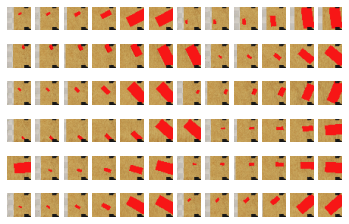

In [12]:
%matplotlib inline
for i, img_idx in enumerate(np.arange(10, 1450, 20)):
    plt.subplot(6, 12, i+1)
    plt.imshow(train_imgs[img_idx])
    plt.axis('off')

NameError: name 'masked1' is not defined

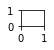

In [13]:
%matplotlib inline
for i, img_idx in enumerate(np.arange(0, 12*12, 1)):
    plt.subplot(12, 12, i+1)
    plt.imshow(masked1[img_idx])
    plt.axis('off')

In [20]:
train_y.min(0)

array([-0.05594371, -0.0949236 , -0.0999753 ])

In [37]:
def normalize(x_data, y_data):
    normal_x = x_data / 255
    normal_y = y_data * 10
    return normal_x, normal_y

normal_train_x, normal_train_y = normalize(train_x, train_y)
normal_val_x, normal_val_y = normalize(val_x, val_y)

In [38]:
for i in range(3):
    print(normal_train_x[:,:,:,i].min(), normal_train_x[:,:,:,i].max())
    
for i in range(3):
    print(normal_train_y[:,i].min(), normal_train_y[:,i].max())

0.0784313725490196 0.9686274509803922
0.0 0.8352941176470589
0.0 0.8196078431372549
-0.5594371117605417 0.9428089848614887
-0.9492359985440112 0.9842579578704685
-0.9997530351262791 0.3962874353485191


In [39]:
class DemoDataset(Dataset):
    def __init__(self, data_x, data_y):
        self.x = torch.as_tensor(data_x, dtype=torch.float32).permute(0, 3, 1, 2)
        self.y = torch.as_tensor(data_y, dtype=torch.float32)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_set = DemoDataset(normal_train_x, normal_train_y)
v_set = DemoDataset(normal_val_x, normal_val_y)

train_set.x.shape, train_set.y.shape, v_set.x.shape, v_set.y.shape

(torch.Size([19721, 3, 32, 32]),
 torch.Size([19721, 3]),
 torch.Size([5210, 3, 32, 32]),
 torch.Size([5210, 3]))

In [40]:
model = ConvNet(n_classes=6)
print('MODEL INFO:', model, sep='\n')
sum_total_learnable_params = 0
for param in model.parameters():
    sum_total_learnable_params += np.prod(np.array(param.shape))
print("Number of learnable parameters:", sum_total_learnable_params)

MODEL INFO:
ConvNet(
  (features): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=16, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=16, out_features=6, bias=True)
  )
)
Number of learnable paramete

In [41]:
def train(model, train_set, v_set, lr, bs, stop_criterion, max_epochs, model_name='current_model', device_name='cuda:0'):
    train_loader = DataLoader(train_set, batch_size=bs, shuffle=True, drop_last=True)
    device = torch.device('cuda:0')
    model.to(device)
    vx, vy = v_set.x.to(device), v_set.y.to(device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    loss_logger = {'loss':[], 'vloss':[], 'loss_class':[], 'vloss_class':[]}
    best_v_loss = np.inf
    stop_counter = 0

    for epoch in range(max_epochs):
        with tqdm(train_loader, unit='batch') as tepoch:
            tepoch.set_description(f'Epoch {epoch}/{max_epochs} max ; best_vloss={best_v_loss:.6f}')
            for (x, y) in tepoch:
                model.train()
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                y_pred = model.forward(x)
                loss = criterion(y_pred, y)
                loss.backward()
                optimizer.step()

                tepoch.set_postfix_str(f'loss={loss.item():.6f}', refresh=False)

            model.eval()
            with torch.no_grad():
                loss_logger['loss'].append(loss.item())
                loss_per_class = ((y - y_pred)**2).mean(axis=0).cpu().numpy()
                loss_logger['loss_class'].append(loss_per_class)
                vy_pred = model.forward(vx)
                v_loss_per_class = ((vy - vy_pred)**2).mean(axis=0).cpu().numpy()
                v_loss = v_loss_per_class.mean().item()
                loss_logger['vloss'].append(v_loss)
                loss_logger['vloss_class'].append(v_loss_per_class)
                if v_loss < best_v_loss:
                    best_v_loss = v_loss
                    stop_counter = 0
                    torch.save(model.state_dict(), f'{DIR_PATH}/data/{model_name}.pth')
                else:
                    stop_counter += 1
                    if stop_counter > stop_criterion:
                        print('Early stopping')
                        break

    return loss_logger

In [28]:
model = ConvNet(n_classes=3)
loss_log = train(model, train_set, v_set, lr=0.0005, bs=512, stop_criterion=20, max_epochs=500, model_name=f'nn32_{colors[0]}_no_aug_model')

Epoch 357/500 max ; best_vloss=0.002037: 100%|██████████| 38/38 [00:00<00:00, 76.48batch/s, loss=0.000338]


Early stopping


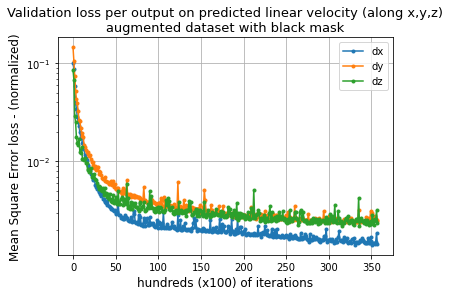

In [29]:
plt.plot(np.stack(loss_log['vloss_class']), '.-')
plt.yscale('log')
#plt.plot(loss_log['loss'], '.-', label='Validation loss')
plt.title("Validation loss per output on predicted linear velocity (along x,y,z)\naugmented dataset with black mask", fontsize=13)
plt.ylabel("Mean Square Error loss - (normalized)", fontsize=12)
plt.xlabel("hundreds (x100) of iterations", fontsize=12)
plt.legend(('dx', 'dy', 'dz'))
plt.grid()

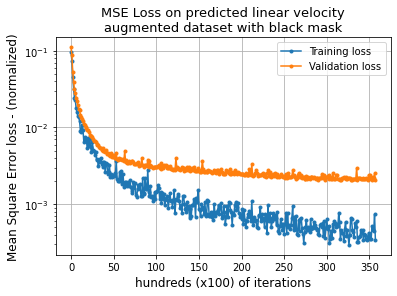

In [30]:
plt.plot(loss_log['loss'], '.-', label='Training loss')
plt.plot(loss_log['vloss'], '.-', label='Validation loss')
plt.title("MSE Loss on predicted linear velocity\naugmented dataset with black mask", fontsize=13)
plt.ylabel("Mean Square Error loss - (normalized)", fontsize=12)
plt.xlabel("hundreds (x100) of iterations", fontsize=12)
plt.yscale('log')
plt.legend()
plt.grid()